In [1]:
# Trench run example
# Start with 2D Example of trench run (this is a metaphor for urban canyon), and then migrate to 3D example
# TODO
# 1. Make it modular (Tilt angle and range differentiated for each camera setting)
# 2. 3D

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Setup n by n grid
# Input: n = number of grid cell
def field(n):
    # Grid Center Location
    center = np.empty(n)
    edge = np.empty(n+1)
    edge[0] = 0
    for i in range(n):
        center[i] = (2*i+1)*1/n*1/2
        edge[i+1] = (i+1)*1/n
    return center, edge

# Output grid center of current position
def grid_check(center, edge, xi):
    x = xi[0]
    y = xi[1]
    n = len(center)
    for i in range(n):
        minedgex = edge[i]
        maxedgex = edge[i+1]
        for j in range(n):
            minedgey = edge[j]
            maxedgey = edge[j+1]
            if minedgex <= x and x <= maxedgex and minedgey <= y and y <= maxedgey:
                grid_center = np.array([[center[i]], [center[j]]])
    return grid_center

In [2]:
# Wrap2Pi
def wrap2pi(x):
    return x%(2*np.pi)

In [3]:
n = 51
x = np.linspace(0, 5, n)
y = np.linspace(0, 5, n)
X,Y = np.meshgrid(x, y)

# Define Initial, Final position of the aggressor
def position(i_x):
    return np.array([x[i_x[0]], y[i_x[1]]])

i_x0 = (int(0.05*n), int(0.05*n))
i_xf = (int(0.95*n), int(0.95*n))
x0 = position(i_x0)
xf = position(i_xf)
print("x0: {}, xf: {}".format(x0, xf))

x0: [0.2 0.2], xf: [4.8 4.8]


In [4]:
# Building Setup
nB = 2
building1 = np.array([0, 1.5, 1, 4])
building2 = np.array([3.5, 5, 1, 4])
building = [building1, building2]

kasdfasdfadf = building[0]
print(kasdfasdfadf[0])

0.0


In [5]:
# Camera Setup
camx = np.array([1.5, 3.5, 1.5, 3.5])
camy = np.array([1, 1, 4, 4])
cam_direc = np.array([np.pi*7/4, np.pi*5/4, np.pi*1/4, np.pi*3/4]) # Center of camera tilt range

# Camera Hardware Constants
tilt_limit = [0, np.pi]
fov_ang = np.deg2rad(20) # [rad]
#fov_rng = 0.475 # [m]
fov_rng = .9 # [m]

def fov_cam(start_ang, ang_lim, rot_vel, fov_ang, fov_rng, t):
    # Compute Camera angle (centerline of FOV) at each timestamp t
    ang_prev = start_ang
    fov_ang_vec = np.zeros(len(t)-1)
    dt = t[1]-t[0]
    # Iteration until it hits the angle limit
    iter_lim = 2*(ang_lim[1]-ang_lim[0])/rot_vel
    for i in range(len(t)-1):
        if i < iter_lim/2:
            fov_ang_curr = ang_prev + rot_vel*dt
        # Camera rotates back once reached its rotation limit
        else:
            fov_ang_curr = ang_prev - rot_vel*dt
        ang_prev = fov_ang_curr
        
        fov_ang_vec[i] = fov_ang_curr
    return fov_ang_vec

def camera_setup(camx, camy, cam_direc):
    # Assume all cameras are identical
    n_cam = len(camx)
    rot_vel = 2*(tilt_limit[1]-tilt_limit[0])/n # [rad/unit time]
    endtime = int(tilt_limit[1]*2/rot_vel)
    
    # Initialize emmpty storage
    ang_lim = np.zeros((n_cam,2))
    start_ang = np.zeros((n_cam,1))    
    tvec = np.zeros((n_cam, int(tilt_limit[1]*2/rot_vel)))
    camvec = np.zeros((n_cam, tvec.shape[1]-1))
    
    
    for i in range(n_cam):
        ang_limi = [cam_direc[i]-(tilt_limit[1]-tilt_limit[0])/2, cam_direc[i]+(tilt_limit[1]-tilt_limit[0])/2]
        start_angi = ang_limi[0] # [rad]
        ti = np.linspace(0, endtime-1, endtime)
        
        # Store computed variables
        ang_lim[i,:] = ang_limi
        start_ang[i] = start_angi
        tvec[i,:] = ti
        
        # Compute fov_cam
        fov_ang_veci = fov_cam(start_angi, ang_limi, rot_vel, fov_ang, fov_rng, ti)
        camvec[i,:] = fov_ang_veci
        
    # Camera Positoin
    campos = np.array([camx, camy]).transpose()

    return campos, n_cam, rot_vel, start_ang, endtime, tvec, ang_lim, camvec

campos, n_cam, rot_vel, start_ang, endtime, tvec, ang_lim, camvec = camera_setup(camx, camy, cam_direc)

for i in range(n_cam):
    print("campos: {}, {}".format(campos[i,0], campos[i,1]))
print("camvec length: {}".format(len(camvec[0])))

# Define Initial, Final position of the Camera FOV (centerline)
end_in = np.array([int(len(tvec[0])/2+20), int(len(tvec[1])/2)+20, int(len(tvec[2])/2)+20, int(len(tvec[2])/2)+20]) #random.randint(0, len(t)-1)
end_ang = np.array([camvec[0, end_in[0]], camvec[1, end_in[1]], camvec[2, end_in[2]], camvec[3, end_in[3]]]) # Arbirary number for now
if len(end_in) != n_cam:
    raise Exception("number of camera mismatch")
    print("end_index: {}, FOV angle at final point[deg]: {}".format(end_in, np.rad2deg(end_ang)))
for i in range(n_cam):
    print("end_index: {}, FOV angle at final point[deg]: {}, Tilt Limit: {}".format(end_in[i], np.rad2deg(end_ang[i]), np.rad2deg(ang_lim[i])))

campos: 1.5, 1.0
campos: 3.5, 1.0
campos: 1.5, 4.0
campos: 3.5, 4.0
camvec length: 50
end_index: 45, FOV angle at final point[deg]: 267.3529411764705, Tilt Limit: [225. 405.]
end_index: 45, FOV angle at final point[deg]: 177.3529411764706, Tilt Limit: [135. 315.]
end_index: 45, FOV angle at final point[deg]: -2.647058823529425, Tilt Limit: [-45. 135.]
end_index: 45, FOV angle at final point[deg]: 87.3529411764706, Tilt Limit: [ 45. 225.]


(-0.1, 5.1)

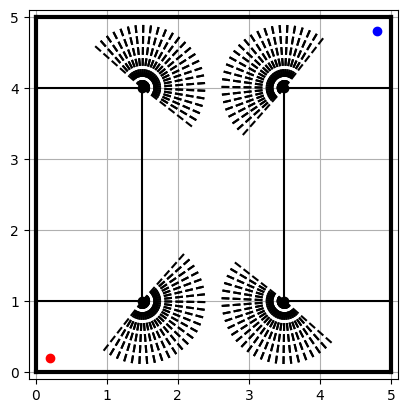

In [6]:
# Visualization for Initial Positions
fig = plt.figure()
# Visualization Purpose
for ind in range(n_cam):
    # Plot Camera Position
    plt.plot(campos[ind,0], campos[ind,1], 'ok')

    # Plot Camera FOV
    for k in range(len(camvec[ind])):
        theta = camvec[ind, k]
        xend = campos[ind,0]+fov_rng*np.cos(theta)
        yend = campos[ind,1]+fov_rng*np.sin(theta)
        plt.plot([campos[ind,0], xend], [campos[ind,1], yend], '--k')
        
# Building
for b in range(nB):
    bcoor = building[b]
    plt.plot([bcoor[0], bcoor[1]], [bcoor[2], bcoor[2]], '-k')
    plt.plot([bcoor[0], bcoor[1]], [bcoor[3], bcoor[3]], '-k')
    plt.plot([bcoor[0], bcoor[0]], [bcoor[2], bcoor[3]], '-k')
    plt.plot([bcoor[1], bcoor[1]], [bcoor[2], bcoor[3]], '-k')

# Plot x0, xf
plt.plot(x0[0], x0[1], 'or')
plt.plot(xf[0], xf[1], 'ob')

# Boxing the grid edge
# Horizontal
plt.plot([x[0], x[-1]], [y[0], y[0]], '-k', linewidth=3)
plt.plot([x[0], x[-1]], [y[-1], y[-1]], '-k', linewidth=3)
# Vertical
plt.plot([x[0], x[0]], [y[0], y[-1]], '-k', linewidth=3)
plt.plot([x[-1], x[-1]], [y[0], y[-1]], '-k', linewidth=3)

# Plot Settings
plt.grid()
plt.axis('square')
tol = 0.1
plt.xlim(-tol, x[-1]+tol)
plt.ylim(-tol, y[-1]+tol)

In [7]:
# Compute Cost Function
def costfunc(x0, x1):
    # How do we add restriction from camera FOV?
    s = np.sqrt((x0[0]-x1[0])**2 + (x0[1]-x1[1])**2)
    return s

In [8]:
import copy

# Initialize Final Point
i_x_prev = i_xf
i_theta_prev = end_ang
i_theta = i_theta_prev
i_x = i_x_prev
V = np.zeros((n, n))
live = [[i_x[0], i_x[1]]]
live_hist = {}
live_hist['0'] = live

commentTrigger = False

# Bound within map
def bound(i_x):
    return (i_x[0] >= 0 and i_x[0]<n and i_x[1] >= 0 and i_x[1]<n)

# Bound outside of camera FOV
def bound_cam(i_x, campos, fov_ang_curr, fov_ang, fov_rng):
    # Convert i_x to position
    i_xPos = position(i_x)
    # distance to node
    dist = np.sqrt((campos[0]-i_xPos[0])**2 + (campos[1]-i_xPos[1])**2)
    # Angle to node
    ang = np.arctan2(i_xPos[1]-campos[1], i_xPos[0]-campos[0])
    return fov_ang_curr+fov_ang/2-wrap2pi(ang)>=0 and fov_ang_curr-fov_ang/2-wrap2pi(ang)<=0 and fov_rng - dist >= 0

def bound_building(i_x, building):
    # building: [x0, x1, y0, y1]
    currpos = position(i_x)
    bcheck = np.zeros((nB,1))
    for b in range(nB):
        bnow = building[b]
        bcheck[b] = (currpos[0] >= bnow[0] and currpos[0] <= bnow[1] and currpos[1] >= bnow[2] and currpos[1] <= bnow[3])
    sumcheck = 0
    for b in range(nB):
        sumcheck += bcheck[b]
    return sumcheck


# Possible Actions
movement = [
    (1, 0), (-1, 0),  # Horizontal
    (0, 1), (0, -1),  # Vertical
    (0, 0)           # Stationary
    , (1, 1), (1, -1), (-1, 1), (-1, -1) # Diagonal
]

# Compute moves from current node
V_data = []
counter = 0
kek = end_in
while len(live) > 0:
    fig = plt.figure()
    new = set()
    # Bound iteration between camvec
    end_in_prev = kek
    for j in range(n_cam):
        if end_in_prev[j] > len(camvec[j]):
            end_in_prev[j] = end_in_prev[j] - len(camvec[j])
        elif end_in_prev[j] < 0:
            end_in_prev[j] = end_in_prev[j] + len(camvec[j])
    # Populate Node for cost function
    
    for p in live:
        pcheck = np.zeros((n_cam,1))
        # Check Camera State
        for j in range(n_cam):
            pcheck[j] = bound(p) and not bound_cam(p, campos[j], camvec[j, end_in_prev[j]], fov_ang, fov_rng) and not bound_building(p, building)
            
        # If p is out of all camera bound
        if all(pcheck):
            for a in movement:
                pacheck = np.zeros((n_cam,1))
                pa = (p[0] - a[0], p[1] - a[1])
                # Check Camera State
                for j in range(n_cam):
                    pacheck[j] = bound(pa) and not bound_cam(pa, campos[j], camvec[j, end_in_prev[j]], fov_ang, fov_rng) and not bound_building(pa, building)
                #If pa is out of all camera bound
                if all(pacheck):
                    V_new = costfunc(p, pa) + V[p[0], p[1]]
                    V_old = V[pa[0], pa[1]]
                    if V_old == 0 or V_new < V_old:
                        V[pa[0], pa[1]] = V_new
                        new.add((pa[0], pa[1]))
                        temp = position(pa)
                        plt.plot(temp[0], temp[1], 'xb')
    live = new
    key = str(counter)
    live_hist[key] = live
    V_data.append(copy.copy(V))
    kek = end_in_prev - 1
    counter += 1
    
    # ===============================
    # Visualization Purpose
    plt.pcolor(X.T, Y, V_data[-1], vmin=V_data[-1].min(), vmax=V_data[-1].max())
    for ind in range(n_cam):
        # Plot Camera Position
        plt.plot(campos[ind,0], campos[ind,1], 'or')

        # Plot Camera FOV
        k = end_in_prev[ind]
        theta = camvec[ind, k]
        xend = campos[ind,0]+fov_rng*np.cos(theta)
        yend = campos[ind,1]+fov_rng*np.sin(theta)
        plt.plot([campos[ind,0], xend], [campos[ind,1], yend], '--r')

        # FOV LOS
        h = fov_rng*np.tan(fov_ang/2)
        Rprime = np.sqrt(h**2 + fov_rng**2)

        xprime1 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[ind, k]+fov_ang/2)]
        yprime1 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[ind, k]+fov_ang/2)]
        xprime2 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[ind, k]-fov_ang/2)]
        yprime2 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[ind, k]-fov_ang/2)]
        plt.plot(xprime1, yprime1, '-r')
        plt.plot(xprime2, yprime2, '-r')

    for b in range(nB):
        bcoor = building[b]
        plt.plot([bcoor[0], bcoor[1]], [bcoor[2], bcoor[2]], '-k')
        plt.plot([bcoor[0], bcoor[1]], [bcoor[3], bcoor[3]], '-k')
        plt.plot([bcoor[0], bcoor[0]], [bcoor[2], bcoor[3]], '-k')
        plt.plot([bcoor[1], bcoor[1]], [bcoor[2], bcoor[3]], '-k')
        
    # Plot x0, xf
    plt.plot(x0[0], x0[1], 'or')
    plt.plot(xf[0], xf[1], 'ob')

    # Remaining Plotting
    plt.grid()
    tol = 0.1
    plt.xlim(-tol, x[-1]+tol)
    plt.ylim(-tol, y[-1]+tol)
#    if counter >= 5 and counter < 12:
    #plt.show()
#    else:
    plt.close()
    
print("Length V_data: {}".format(len(V_data)))

Length V_data: 64


In [9]:
import matplotlib.animation

# video animation
from tempfile import NamedTemporaryFile
from IPython.display import HTML

inflate_camera_view = 5
save_path = '~/ros2_ws/src/cognis_UAM/notebook/video/'

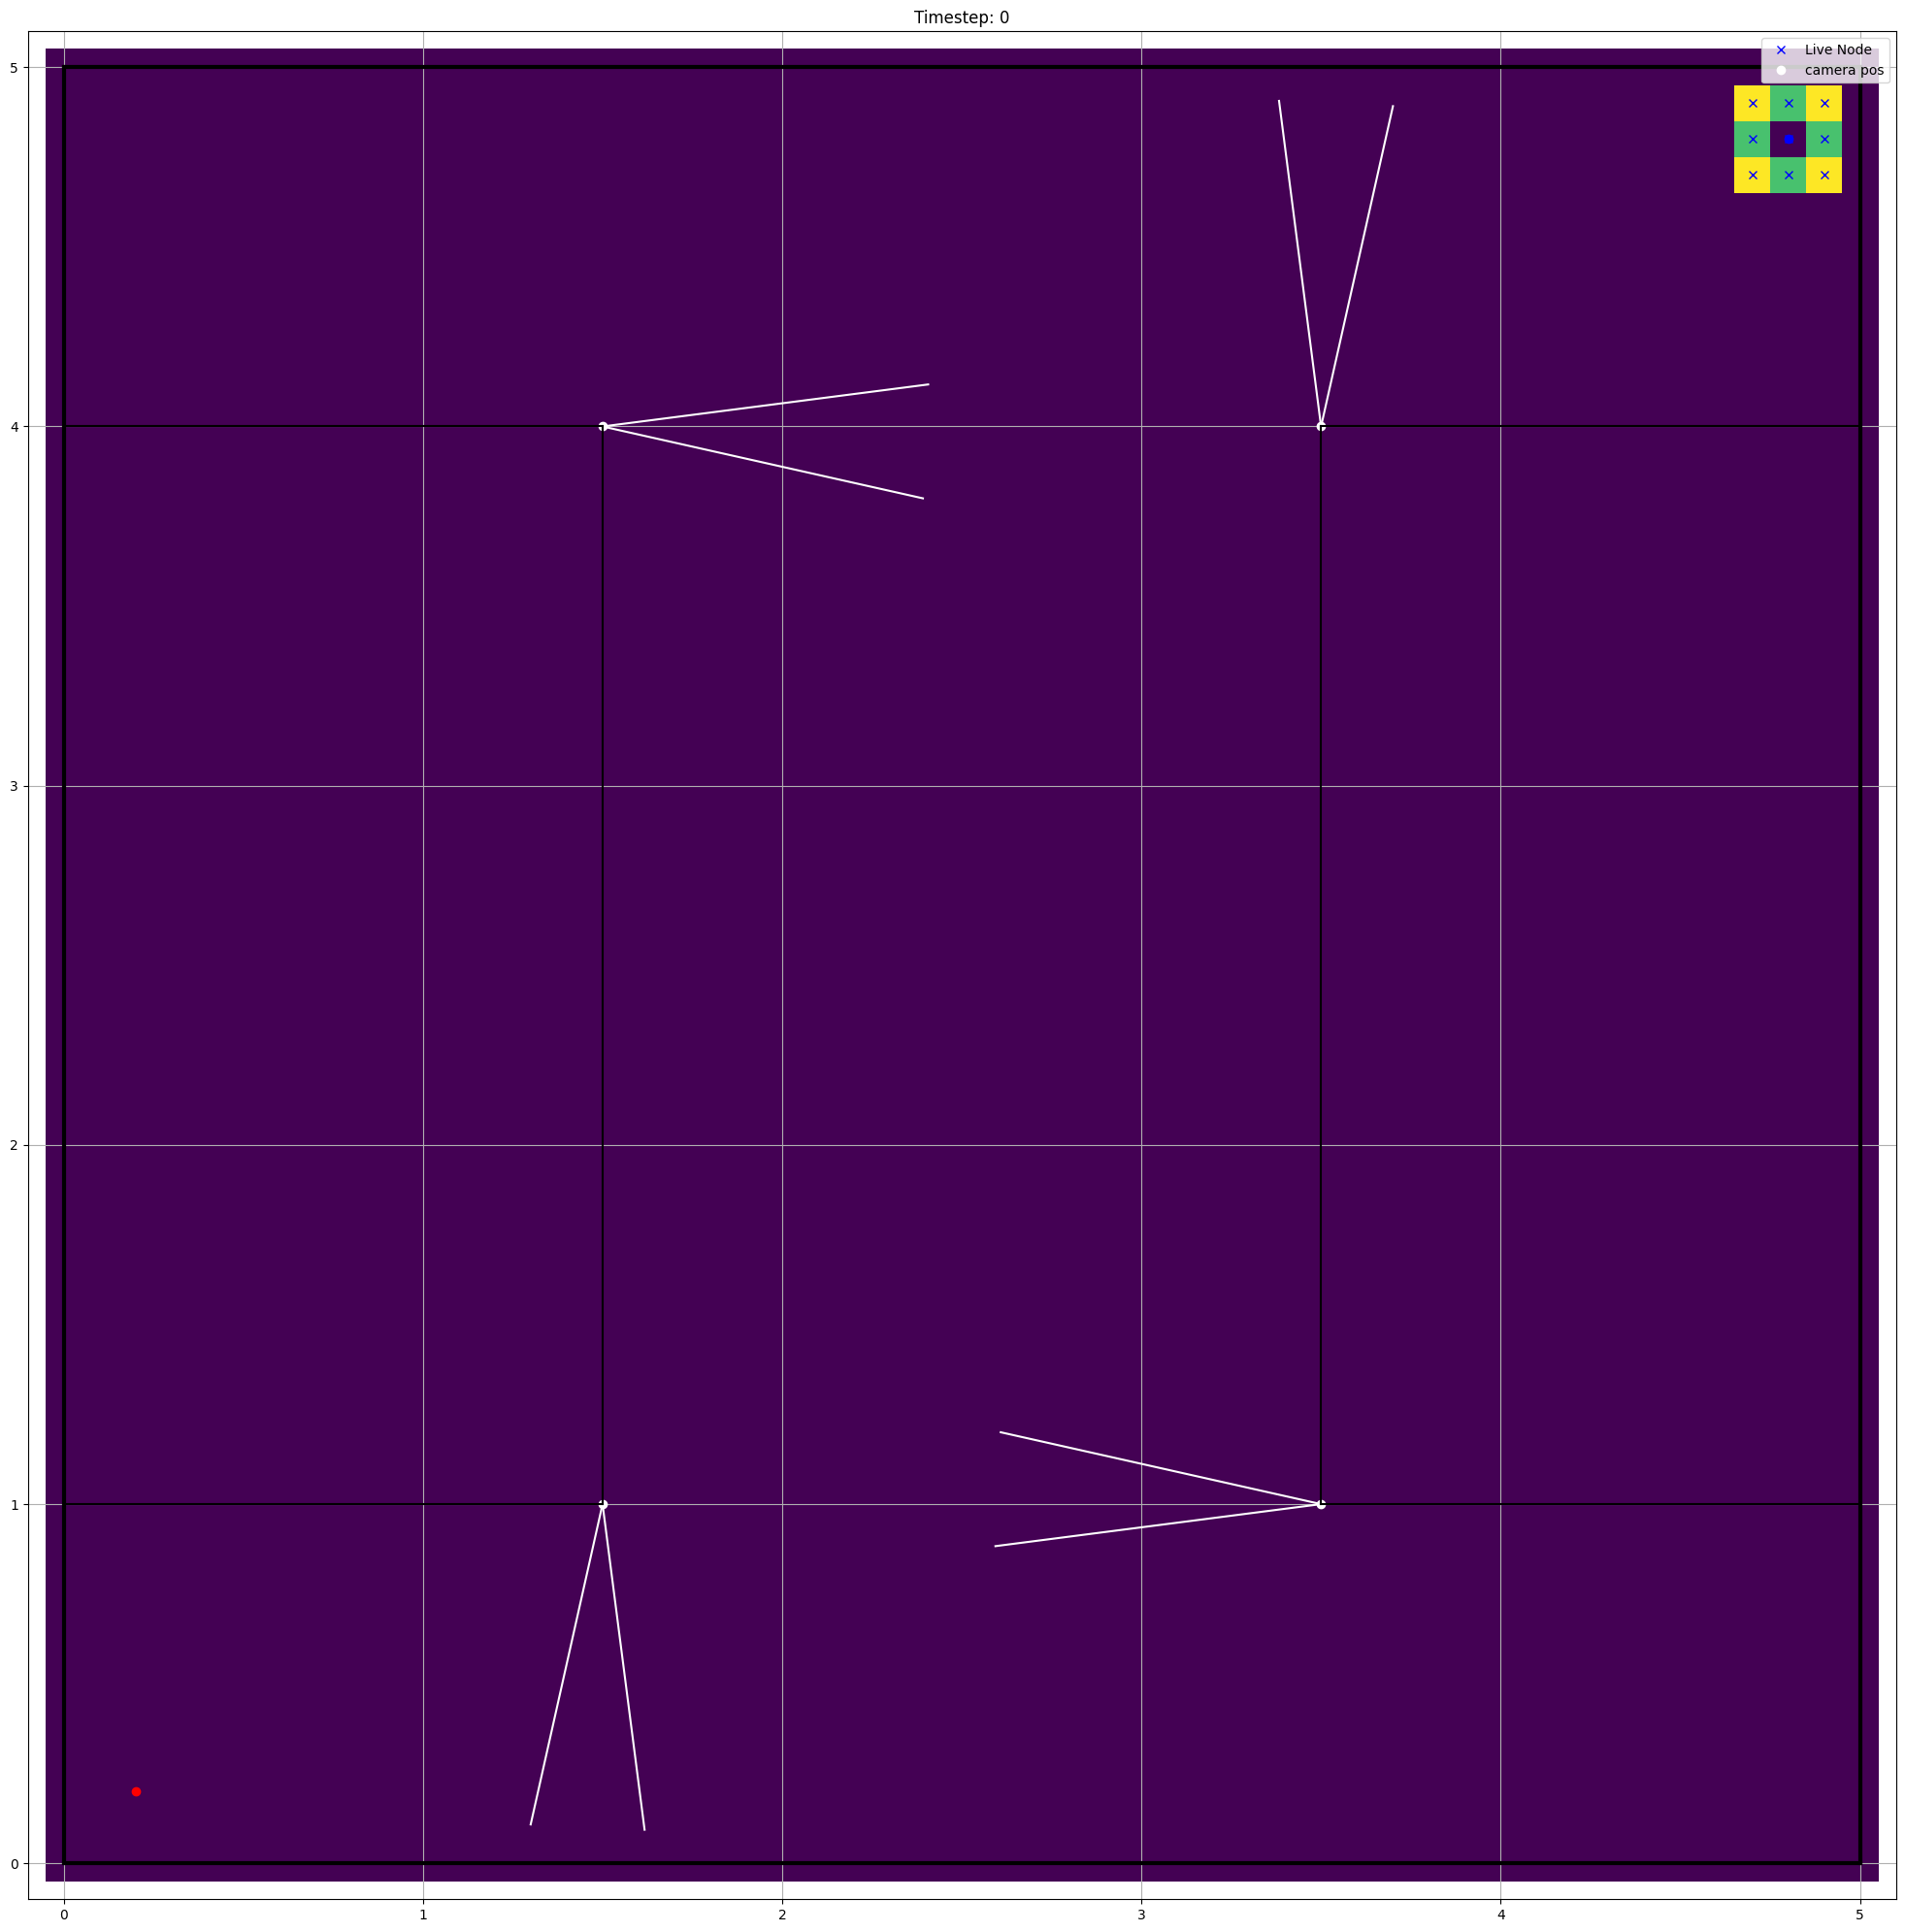

In [10]:
def anim_dyn_prog(V_data):
    nV = len(V_data)
    fig = plt.figure(figsize=(x[-1]*inflate_camera_view, y[-1]*inflate_camera_view))
    plt.pcolor(X, Y, V_data[0].T, vmin=V_data[-1].min(), vmax=V_data[-1].max())   
    
    def update(i):
        fig.clear()
        if i < nV:
            # Grid Coloring
            plt.pcolor(X, Y, V_data[i].T, vmin=V_data[i].min(), vmax=V_data[i].max())
            
            # Node Population
            # Find current index from dictionary and plot populated node
            curr_key = str(i)
            liveNode = live_hist[curr_key]
            primaris = 0
            for p in liveNode:
                cawl = position(p)
                plt.plot(cawl[0], cawl[1], 'xb', label='Live Node' if primaris == 0 else "")
                primaris += 1
            
            # Camera Visualization
            for ind in range(n_cam):
                # Plot Camera Position
                plt.plot(campos[ind,0], campos[ind,1], 'ow', label='camera pos' if ind == 0 else "")

                # Plot Camera FOV
                k = end_in[ind]-i%len(tvec[ind])
                if k < 0:
                    k = k + len(tvec[ind])-1
                elif k > len(tvec[ind]):
                    k = k - len(tvec[ind])-1
                theta = camvec[ind, k]
                xend = campos[ind,0]+fov_rng*np.cos(theta)
                yend = campos[ind,1]+fov_rng*np.sin(theta)
                #plt.plot([campos[ind,0], xend], [campos[ind,1], yend], '--w')

                # FOV LOS
                h = fov_rng*np.tan(fov_ang/2)
                Rprime = np.sqrt(h**2 + fov_rng**2)

                xprime1 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[ind, k]+fov_ang/2)]
                yprime1 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[ind, k]+fov_ang/2)]
                xprime2 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[ind, k]-fov_ang/2)]
                yprime2 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[ind, k]-fov_ang/2)]
                plt.plot(xprime1, yprime1, '-w')
                plt.plot(xprime2, yprime2, '-w')

            for b in range(nB):
                bcoor = building[b]
                plt.plot([bcoor[0], bcoor[1]], [bcoor[2], bcoor[2]], '-k')
                plt.plot([bcoor[0], bcoor[1]], [bcoor[3], bcoor[3]], '-k')
                plt.plot([bcoor[0], bcoor[0]], [bcoor[2], bcoor[3]], '-k')
                plt.plot([bcoor[1], bcoor[1]], [bcoor[2], bcoor[3]], '-k')
                
            # Plot x0, xf
            plt.plot(x0[0], x0[1], 'or')
            plt.plot(xf[0], xf[1], 'ob')

            # Boxing the grid edge
            # Horizontal
            plt.plot([x[0], x[-1]], [y[0], y[0]], '-k', linewidth=3)
            plt.plot([x[0], x[-1]], [y[-1], y[-1]], '-k', linewidth=3)
            # Vertical
            plt.plot([x[0], x[0]], [y[0], y[-1]], '-k', linewidth=3)
            plt.plot([x[-1], x[-1]], [y[0], y[-1]], '-k', linewidth=3)

            # Plot Settings
            plt.grid()
            plt.axis('square')
            tol = 0.1
            plt.xlim(-tol, x[-1]+tol)
            plt.ylim(-tol, y[-1]+tol)
            plt.legend(loc="upper right")
            plt.title("Timestep: {}".format(i))

    return matplotlib.animation.FuncAnimation(fig, update, frames=nV, interval=100)

# Save Animation into MP4
anim = anim_dyn_prog(V_data)
anim.save('Vdata_Propagation_'+str(n_cam)+'Cam_Buliding_1.mp4', fps=5)

In [11]:
# Sanity Check
SanityCheck = type(None)

# Comment Trigger
commentTrigger = False

# Compute Optimal Path
p = i_x0
p_hist_opt = [p]
count = 0
while p != i_xf:
    #print('======================')
    #print("count: {}".format(count))
    fig = plt.figure(figsize=(x[-1]*inflate_camera_view, y[-1]*inflate_camera_view))
    plt.pcolor(X, Y, V_data[-1].T, vmin=V_data[-1].min(), vmax=V_data[-1].max())
    # Find current time to check where the camera angle is:
    curr_time = count%len(camvec[0])
    next_time = curr_time + 1
    if next_time >= len(camvec[0]):
        next_time = next_time-len(camvec[0])

    for ind in range(n_cam):
        # Plot Camera Position
        plt.plot(campos[ind,0], campos[ind,1], 'ow', label = 'Camera Position' if ind == 0 else "")

        # Plot Camera FOV
        k = curr_time
        #print('i: {}, k: {}, end_in: {}'.format(i, k, end_in))
        theta = camvec[ind, k]
        xend = campos[ind,0]+fov_rng*np.cos(theta)
        yend = campos[ind,1]+fov_rng*np.sin(theta)
        plt.plot([campos[ind,0], xend], [campos[ind,1], yend], '--w')

        # FOV LOS
        h = fov_rng*np.tan(fov_ang/2)
        Rprime = np.sqrt(h**2 + fov_rng**2)

        xprime1 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[ind,k]+fov_ang/2)]
        yprime1 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[ind,k]+fov_ang/2)]
        xprime2 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[ind,k]-fov_ang/2)]
        yprime2 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[ind,k]-fov_ang/2)]
        plt.plot(xprime1, yprime1, '-w')
        plt.plot(xprime2, yprime2, '-w', label = 'Camera FOV' if ind == 0 else "")

    # Populate Node for cost function
    pcheck = np.zeros((n_cam,1))
    # Check Camera State
    for j in range(n_cam):
        pcheck[j] = bound(p) and not bound_cam(p, campos[j], camvec[j, curr_time], fov_ang, fov_rng) and not bound_building(p, building)

    # If p is out of all camera bound
    if all(pcheck):
        skitarii = position(p)
        plt.plot(skitarii[0], skitarii[1], 'xb')
        pa_opt = None
        V_opt = None
        for a in movement:
            pacheck = np.zeros((n_cam,1))
            pa = (p[0] + a[0], p[1] + a[1])
            # Check Camera State
            for j in range(n_cam):
                pacheck[j] = bound(pa) and not bound_cam(pa, campos[j], camvec[j, next_time], fov_ang, fov_rng) and not bound_building(pa, building)

            #If pa is out of all camera bound
            if all(pacheck):
                V_new = V[pa[0], pa[1]]
                if pa_opt is None or (V_new < V_opt):
                    V_opt = V_new
                    pa_opt = pa
                    plt.plot(position(pa)[0], position(pa)[1], 'xr')
            if pa == i_xf: break
    if count > 1000: break
    p = pa_opt
    # Check if p is empty
    # If p is empty: There is no solution exist s.t. x0 and xf can be connected without detection
    if isinstance(p, SanityCheck):
        break
    else:
        p_hist_opt.append(p)
        count += 1
        
    for b in range(nB):
        bcoor = building[b]
        plt.plot([bcoor[0], bcoor[1]], [bcoor[2], bcoor[2]], '-k')
        plt.plot([bcoor[0], bcoor[1]], [bcoor[3], bcoor[3]], '-k')
        plt.plot([bcoor[0], bcoor[0]], [bcoor[2], bcoor[3]], '-k')
        plt.plot([bcoor[1], bcoor[1]], [bcoor[2], bcoor[3]], '-k')
        
    # Plot x0, xf
    plt.plot(x0[0], x0[1], 'or', label = 'Initial Point')
    plt.plot(xf[0], xf[1], 'ob', label = 'Final Point')

    # Boxing the grid edge
    # Horizontal
    plt.plot([x[0], x[-1]], [y[0], y[0]], '-k', linewidth=3)
    plt.plot([x[0], x[-1]], [y[-1], y[-1]], '-k', linewidth=3)
    # Vertical
    plt.plot([x[0], x[0]], [y[0], y[-1]], '-k', linewidth=3)
    plt.plot([x[-1], x[-1]], [y[0], y[-1]], '-k', linewidth=3)

    # Plot Settings
    plt.grid()
    plt.axis('square')
    tol = 0.1
    plt.xlim(-tol, x[-1]+tol)
    plt.ylim(-tol, y[-1]+tol)
    plt.legend(loc="upper right")
    #plt.show()
    plt.close()

pos_hist_opt = np.array([position(p) for p in p_hist_opt])
print(len(pos_hist_opt))
#print(pos_hist_opt)

65


In [12]:
def anim_dyn_prog(V_data):
    nV = len(V_data)
    nP = len(pos_hist_opt)
    fig = plt.figure(figsize=(x[-1]*inflate_camera_view, y[-1]*inflate_camera_view))
    plt.pcolor(X, Y, V_data[0].T, vmin=V_data[-1].min(), vmax=V_data[-1].max())
    
    def update(i):
        fig.clear()
        if i < nP:
            # Plot from t0
            plt.pcolor(X, Y, V_data[nV-1].T, vmin=V_data[-1].min(), vmax=V_data[-1].max())

            # Plot Time Varying FOV
            plt.plot(pos_hist_opt[:i,0], pos_hist_opt[:i,1], '--k', label = 'Aggressor Position History')
            plt.plot(pos_hist_opt[i-1:i+1,0], pos_hist_opt[i-1:i+1,1], '-k')
            plt.plot(pos_hist_opt[i,0], pos_hist_opt[i,1], 'ok', label = 'Aggressor')
            for ind in range(n_cam):
                # Plot Camera Position
                plt.plot(campos[ind,0], campos[ind,1], 'ow', label = 'Camera Position' if ind == 0 else "")

                # Plot Camera FOV
                k = end_in[ind] - nP + i + 1
                if k >= 0:
                    k = k%len(camvec[0])
                else:
                    k = (k+len(camvec[0]))%len(camvec[0])
                #print('i: {}, k: {}, end_in: {}'.format(i, k, end_in))
                theta = camvec[ind,k%len(camvec[0])]
                xend = campos[ind,0]+fov_rng*np.cos(theta)
                yend = campos[ind,1]+fov_rng*np.sin(theta)
                #plt.plot([campos[ind,0], xend], [campos[ind,1], yend], '--r')

                # FOV LOS
                h = fov_rng*np.tan(fov_ang/2)
                Rprime = np.sqrt(h**2 + fov_rng**2)

                xprime1 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[ind,k]+fov_ang/2)]
                yprime1 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[ind,k]+fov_ang/2)]
                xprime2 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[ind,k]-fov_ang/2)]
                yprime2 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[ind,k]-fov_ang/2)]
                plt.plot(xprime1, yprime1, '-w')
                plt.plot(xprime2, yprime2, '-w', label = 'Camera FOV' if ind == 0 else "")
            
        # Timer Indication
        plt.title('Timestep: {}'.format(i))

        # Plot x0, xf
        plt.plot(x0[0], x0[1], 'or', label = 'Initial Point')
        plt.plot(xf[0], xf[1], 'ob', label = 'Final Point')

        # Boxing the grid edge
        # Horizontal
        plt.plot([x[0], x[-1]], [y[0], y[0]], '-k', linewidth=3)
        plt.plot([x[0], x[-1]], [y[-1], y[-1]], '-k', linewidth=3)
        # Vertical
        plt.plot([x[0], x[0]], [y[0], y[-1]], '-k', linewidth=3)
        plt.plot([x[-1], x[-1]], [y[0], y[-1]], '-k', linewidth=3)

        # Plot Settings
        plt.grid()
        plt.axis('square')
        tol = 0.1
        plt.xlim(-tol, x[-1]+tol)
        plt.ylim(-tol, y[-1]+tol)
        plt.legend(loc="upper right")

    return matplotlib.animation.FuncAnimation(fig, update, frames=nP, interval=50, repeat=False)

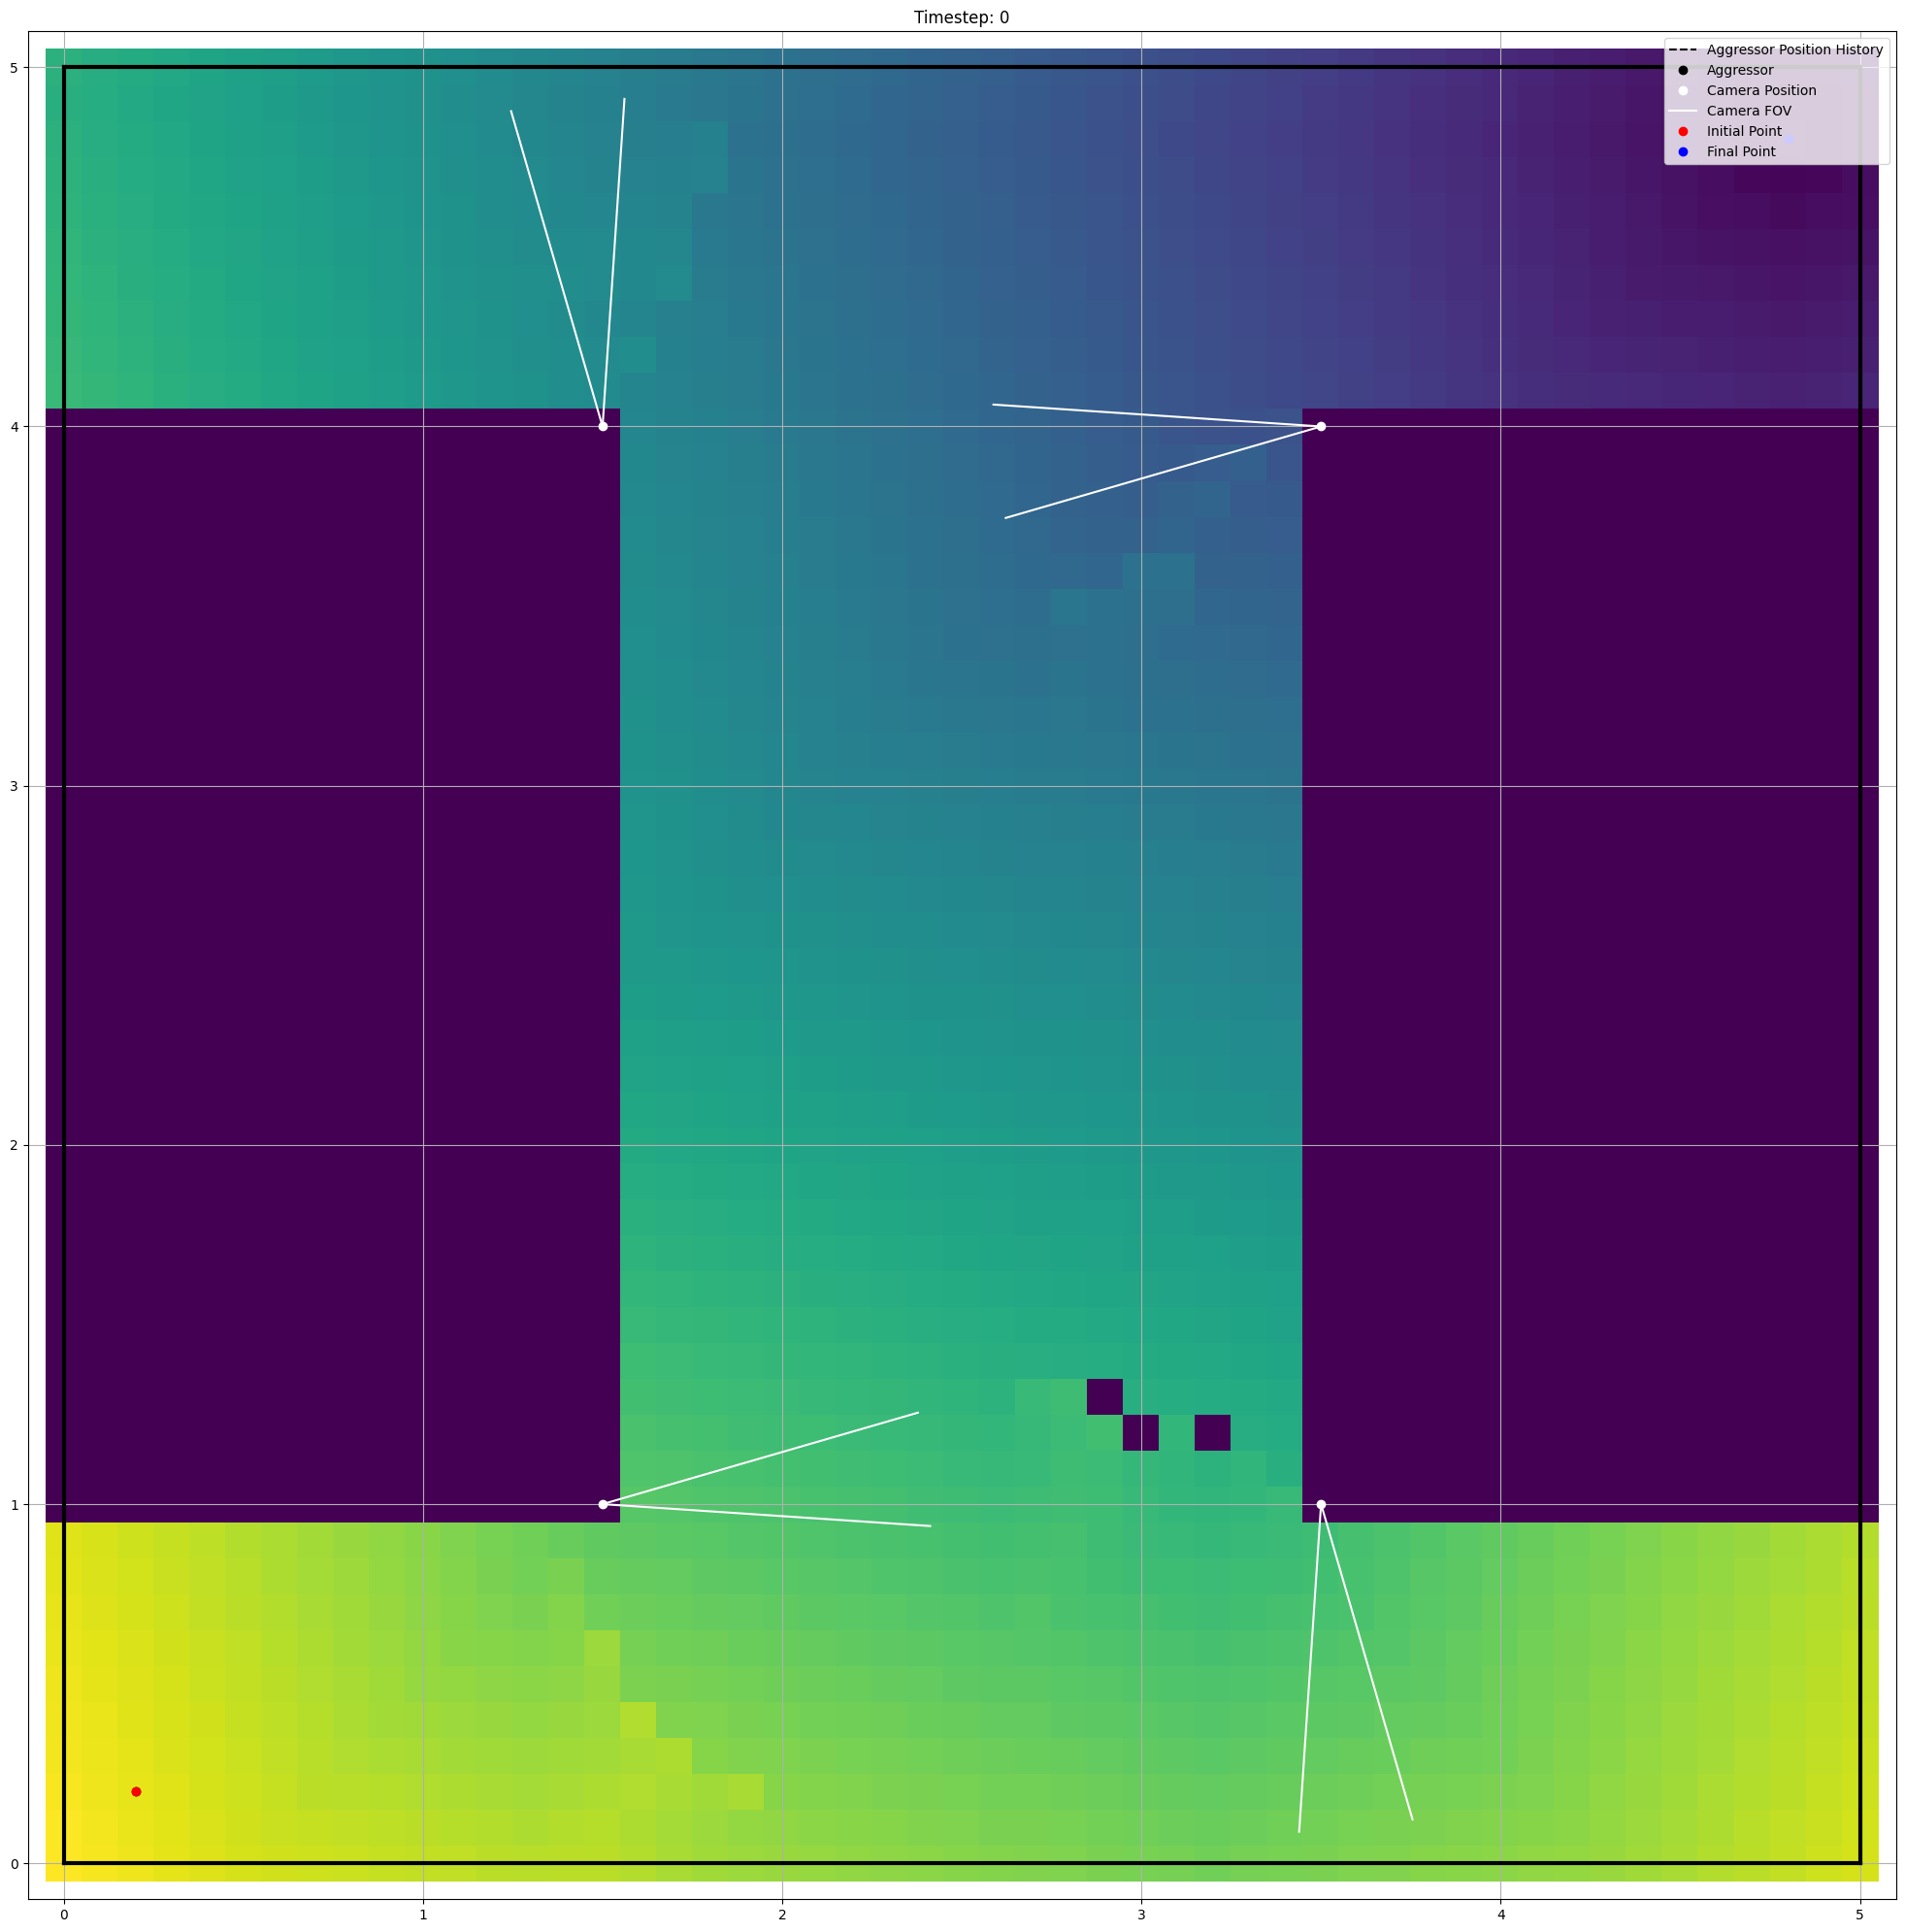

In [13]:
anim = anim_dyn_prog(V_data)
anim.save('Aggressor_Insertion_'+str(n_cam)+'Cam '+str(n)+' frame_Building_1.mp4', fps=5)